# Predicing level of acceptability of cars using machine learning

by Danish Karlin Isa, Nicholas Varabioff, Ximin Xu, Zuer Zhong

In [1]:
# imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
RandomizedSearchCV,
cross_validate,
train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import  MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay 
import matplotlib.pyplot as plt
import altair as alt

## Summary

In this project, we attempt to predict the level of acceptability of cars by building a machine learning model.
To choose the best model for this task, 
we utilised several common machine learning models, 
and found out that the SVM RBF classifier achieved the best train and cross-validation scores,
with a test accuracy of 0.952.
On the 346 test data cases, 
it correctly predicted the targets of 343 examples,
while there were only 3 examples with incorrect predicted targets.

The SVM RBF model also showed exceptional ability in determining the acceptability of cars as seen in the confusion matrix, classification reports, and relatively high scores for precision, recall and F1.
However, a slight decrease in classification precision was observed for the “good” category,
together with a relatively lower recall score of 0.86 that indicates occasional classification errors. 
Nonetheless, the results obtained from this analysis further exemplifies the ability of the SVM RBF model in handling nonlinear decision boundaries. 
This makes the SVM RBF model a solid choice for this project.




## Introduction

The Car Evaluation Dataset was created as part of efforts to understand the factors that affect the acceptability of cars among consumers. 
These factors include buying price of a car, maintenance costs, passenger and luggage capacity, and safety. 
The goal of this project is to develop a machine learning model that can evaluate the quality of a car based on its attributes to help buyers make a more informed decision for their next car purchase.

The RBF SVM model is known for its effectiveness in nonlinear classification tasks, and its use is particularly useful at navigating the complexities of car evaluation. We expected the model to perform well. In our tests, we also found that it outperformed other models such as Naive Bayes and logistic regression. Our findings suggest a potential class imbalance or capacity limitation in the model's ability to adequately capture the nuances of the “good” classes. This raises questions about the ideal modeling approach for such datasets.

## Methods



### Data

The dataset that was used in this project is of Car Evaluation Database created by the efforts of M. Bohanec and V. Rajkovic in the early 1990s. 
It is sourced from the UCI Machine Learning Repository and is publicly available for research and can be found in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/19/car+evaluation).
Each row in the dataset details a car’s attributes (each feature is of categorical data type with several levels), which includes:

* Buying price: `low`, `med`, `high`, `vhigh`
* Maintenance cost: `low`, `med`, `high`, `vhigh`
* Number of doors: `2`, `3`, `4`, `5more`
* Seating capacity: `2`, `4`, `more`
* Boot size: `small`, `med`, `big`
* Safety rating: `low`, `med`, `high`

In [2]:
# import raw data
# data located at https://archive.ics.uci.edu/dataset/19/car+evaluation

colnames = ['buying','maint','doors','persons','lug_boot','safety','class']
car_data = pd.read_csv('../data/raw/car.data', names=colnames, header=None)

car_data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


### Exploratory Data Analysis

Exploratory data analysis was carried out on the train dataset.
Here, the counts of records by target and category was visualised to gain a better idea of the dataset.

Through this analysis, we can see that examples with targets as `unacceptable` represent a large proportion of the dataset.

In [4]:
# train test split, export to csv
np.random.seed(522)

car_train, car_test = train_test_split(
    car_data, train_size = 0.8, random_state = 522, stratify=car_data['class']
)

car_train.to_csv('../data/processed/car_train.csv')
car_test.to_csv('../data/processed/car_test.csv')

In [5]:
alt.Chart(car_train).mark_bar().encode(
    x=alt.X(alt.repeat('row')),
    y='count()',
    color=alt.Color('class'),
    column='class'
).properties(
    height=100
).repeat(
    row=['buying','maint','doors','persons','lug_boot','safety']
)

alt.RepeatChart(...)

Figure 1: Visualisation of counts by feature and target.

### Preprocessing of dataset for machine learning

In [6]:
# preprocessing

# transform categorical features
car_preprocessor = make_column_transformer(
    (OrdinalEncoder(categories=[['low','med','high','vhigh']]), ['buying']),
    (OrdinalEncoder(categories=[['low','med','high','vhigh']]), ['maint']),
    (OrdinalEncoder(categories=[['2','3','4','5more']]), ['doors']),
    (OrdinalEncoder(categories=[['2','4','more']]), ['persons']),
    (OrdinalEncoder(categories=[['small','med','big']]), ['lug_boot']),
    (OrdinalEncoder(categories=[['low','med','high']]), ['safety']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

car_preprocessor.fit(car_train)
encoded_car_train = car_preprocessor.transform(car_train)
encoded_car_test = car_preprocessor.transform(car_test)

names = car_preprocessor.get_feature_names_out()
encoded_car_train = pd.DataFrame(encoded_car_train, columns=names)
encoded_car_test = pd.DataFrame(encoded_car_test, columns=names)

encoded_car_train.to_csv('../data/encoded_car_train.csv')
encoded_car_test.to_csv('../data/encoded_car_train.csv')

In [7]:
X_train, y_train = car_train.drop(columns=['class']), car_train['class']
X_test, y_test = car_test.drop(columns=['class']), car_test['class']

### Choosing a machine learning model

The core of this project is the machine learning model. Thus, in the next step, several machine learning models will be evaluated.

In [8]:
models = {
    "dummy": DummyClassifier(random_state=123),
    "Decision Tree": DecisionTreeClassifier(random_state=123, max_depth=5),
    "KNN": KNeighborsClassifier(),
    "SVM RBF": SVC(random_state=123),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=123)
}

`cross_validate` from `sklearn` will be used to evaluate the best performing model.

In [9]:
cv_results = []
for model_name, model in models.items():
    pipe = make_pipeline(car_preprocessor, model)
    scores = cross_validate(pipe, X_train, y_train, n_jobs=-1, return_train_score=True, cv=5)
    cv_results.append({
        "model": model_name,
        "mean_train_score": np.mean(scores['train_score']),
        "std_train_score": np.std(scores['train_score']),
        "mean_test_score": np.mean(scores['test_score']),
        "std_test_score": np.std(scores['test_score'])
    })

cv_results_df = pd.DataFrame(cv_results)
cv_results_df

,model,mean_train_score,std_train_score,mean_test_score,std_test_score
0,dummy,0.700434,0.000330,0.700434,0.001324
1,Decision Tree,0.872649,0.003011,0.855295,0.017305
2,KNN,0.969610,0.002833,0.942848,0.010523
3,SVM RBF,0.971239,0.003580,0.952260,0.018302
4,Naive Bayes,0.711288,0.001720,0.707670,0.003501
5,Logistic Regression,0.838458,0.006947,0.833584,0.018662


According to our cross-validation results, 
SVM RBF achieved the highest train and cross-validation scores,
suggesting it is the best model for generalising unseen data. 
Therefore, we will be using SVM RBF for this project.

Next, hyperparameter optimisation will be carried out with `RandomizedSearchCV` to obtain the best model for this project.

In [10]:
param_grid = {
    "svc__gamma": 10.0 ** np.arange(-5, 5, 1),
    "svc__C": 10.0 ** np.arange(-5, 5, 1)
}

svc_pipe = make_pipeline(
    car_preprocessor, 
    SVC(random_state=123)
)

random_search = RandomizedSearchCV(
    svc_pipe, param_distributions=param_grid, n_iter=100, n_jobs= -1, return_train_score=True
)
 
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ordinalencoder-1',
                                                                               OrdinalEncoder(categories=[['low',
                                                                                                           'med',
                                                                                                           'high',
                                                                                                           'vhigh']]),
                                                                               ['buying']),
                                                                              ('ordinalencoder-2',
                                                                               OrdinalEncoder(categories=[['low',
                                                                                                           'med',
                                                                                                           'high',
                                                                                                           'vhigh']]),
                                                                               ['maint']),
                                                                              ('ordinalencoder-3',
                                                                               OrdinalEncoder(categories=[['...
                                                                               OrdinalEncoder(categories=[['low',
                                                                                                           'med',
                                                                                                           'high']]),
                                                                               ['safety'])],
                                                                verbose_feature_names_out=False)),
                                             ('svc', SVC(random_state=123))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'svc__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04]),
                                        'svc__gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])},
                   return_train_score=True)

The visualisations below allow us to gain a better understanding of how each hyperparameter affects the performance of the model.

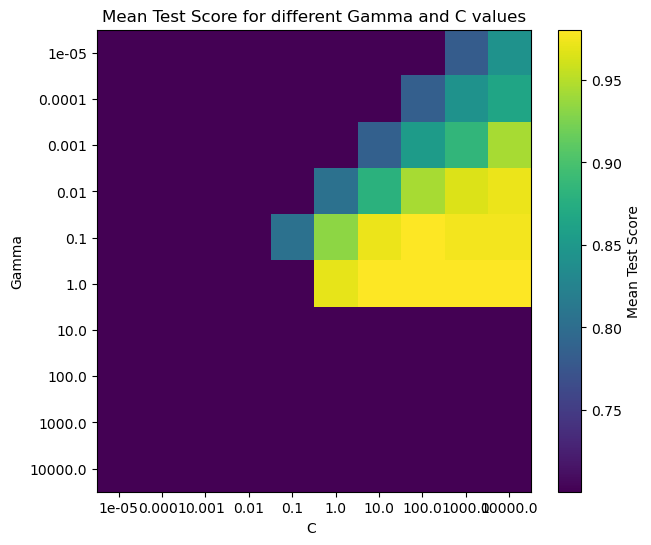

In [11]:
results = pd.DataFrame(random_search.cv_results_)

pivot_table = results.pivot(index="param_svc__gamma", columns="param_svc__C", values="mean_test_score")
plt.figure(figsize=(7, 6))
plt.title("Mean Test Score for different Gamma and C values")
plt.xlabel('C ')
plt.ylabel('Gamma')
plt.imshow(pivot_table, cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar(label='Mean Test Score')
plt.xticks(np.arange(len(pivot_table.columns)), pivot_table.columns)
plt.yticks(np.arange(len(pivot_table.index)), pivot_table.index)
plt.show()

Figure 2: Heat map of test scores obtained during hyperparameter optimisation.

`RandomizedSearchCV` also allows us to obtain the best performing SVM RBF model for this project.

In [12]:
best_model = random_search.best_estimator_
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder-1',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'med',
                                                                              'high',
                                                                              'vhigh']]),
                                                  ['buying']),
                                                 ('ordinalencoder-2',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'med',
                                                                              'high',
                                                                              'vhigh']]),
                                                  ['maint']),
                                                 ('ordinalencoder-3',
                                                  OrdinalEncoder(categories=[['2',
                                                                              '3',
                                                                              '4',
                                                                              '5more']]),
                                                  ['doors']),
                                                 ('ordinalencoder-4',
                                                  OrdinalEncoder(categories=[['2',
                                                                              '4',
                                                                              'more']]),
                                                  ['persons']),
                                                 ('ordinalencoder-5',
                                                  OrdinalEncoder(categories=[['small',
                                                                              'med',
                                                                              'big']]),
                                                  ['lug_boot']),
                                                 ('ordinalencoder-6',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'med',
                                                                              'high']]),
                                                  ['safety'])],
                                   verbose_feature_names_out=False)),
                ('svc', SVC(C=100.0, gamma=0.1, random_state=123))])

In [13]:
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)

0.9913294797687862

As the score report has indicated, our model is extremely well, with very high score on test results. This means that our model is predicting well on unseen data.

## Results & Discussion

After performing hyperparameter optimisation, the RBF SVM model with `C=100.0` and g`amma=0.1` achieved the best performance on the test set with a score of 0.99.
This suggests the model has been generalised well, with high scores on both the train and test sets.

To further improve the model's utility, several changes can be made.
One such change is feeding the model with features that are not just categorical.
Instead, for features such as buying price, maintenance cost and safety features, numeric data should be used.
At the same time, more features can be included, such as the type of car and and fuel efficiency ratings.

By allowing the model to take in more complex data, this may allow the model to make more accurate predictions to let customers make a more informed choice when purchasing a new car.



## References

* Bohanec, M. (1988). Car Evaluation [Dataset]. _UCI Machine Learning Repository._ (https://doi.org/10.24432/C5JP48).
* Makki, S., Mustapha, A., Kassim, J. M., Gharayebeh, E. H., & Alhazmi, M. (2011, April). Employing neural network and naive Bayesian classifier in mining data for car evaluation. In Proc. _ICGST AIML-11 Conference (pp. 113-119)._
* Potdar, K., Pardawala, T. S., & Pai, C. D. (2017). A comparative study of categorical variable encoding techniques for neural network classifiers. _International journal of computer applications, 175(4), 7-9._
* Tanveer, M., Gautam, C., & Suganthan, P. N. (2019). Comprehensive evaluation of twin SVM based classifiers on UCI datasets. _Applied Soft Computing, 83_, 105617.